C:\Users\DELL\AppData\Local\Temp\ipykernel_103540\2867108038.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Epoch 1/650
32/32 [==============================] - 2s 7ms/step - loss: 0.1166
Epoch 2/650
32/32 [==============================] - 0s 7ms/step - loss: 0.0837
Epoch 3/650
32/32 [==============================] - 0s 7ms/step - loss: 0.0565
Epoch 4/650
32/32 [==============================] - 0s 7ms/step - loss: 0.0482
Epoch 5/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0450
Epoch 6/650
32/32 [==============================] - 0s 7ms/step - loss: 0.0410
Epoch 7/650
32/32 [==============================] - 0s 8ms/step - loss: 0.0407
Epoch 8/650
32/32 [==============================] - 0s 8ms/step - loss: 0.0390
Epoch 9/650
32/32 [==============================] - 0s 7ms/step - loss: 0.0390
Epoch 10/650
32/32 [==============================] - 0s 7ms/step - loss: 0.0407
Epoch 11/650
32/32 [==============================] - 0s 7ms/step - loss: 0.0408
Epoch 12/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0387
Epoch 13/650
32/32 [=================

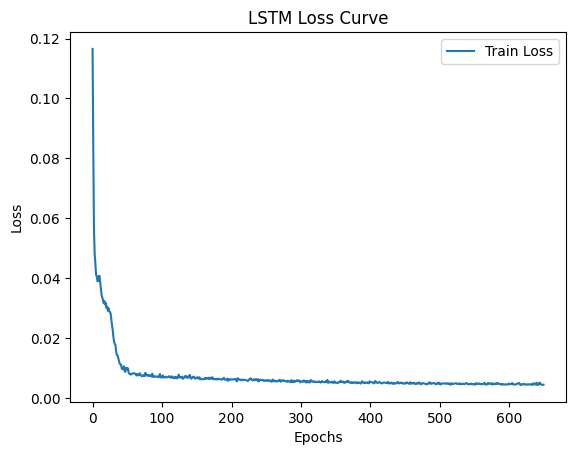

1/1 [==============================] - 0s 308ms/step
Epoch 1/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 2/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0049
Epoch 3/650
32/32 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 4/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 5/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 6/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0048
Epoch 7/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 8/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0043
Epoch 9/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0044
Epoch 10/650
32/32 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 11/650
32/32 [==============================] - 0s 6ms/step - loss: 0.0045
Epoch 12/650
32/32 [==============================] - 0s 5ms/step

KeyboardInterrupt: 

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the datasets
pred_data = pd.read_csv('consumption_battery_data.csv')
pred=pd.read_csv('daily_pred.csv')

# Convert 'datetime' column, inferring format
pred_data['datetime'] = pd.to_datetime(pred_data['datetime'], errors='coerce', dayfirst=True)

# Normalize the data using MinMaxScaler
scaler1 = MinMaxScaler()
scaled_consumption_data = scaler1.fit_transform(pred_data[['power_usage_kW']])


# Prepare sequences for Model 1 (LSTM)
def create_sequences(data, time_steps=24):
    X = []
    y = []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Create sequences for Model 1
time_steps = 24
X1, y1 = create_sequences(scaled_consumption_data, time_steps)

# Split into training set (first 1000 points)
X1_train = X1[:1016]
y1_train = y1[:1016]

# Build Model 1 (LSTM)
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # 7 outputs for temp, humidity, windspeed, cloudcover, solar_radiation, solar_energy, uv_index
    model.compile(optimizer='adam', loss='mse')
    return model

model1 = build_lstm_model((X1_train.shape[1], X1_train.shape[2]))
history = model1.fit(X1_train, y1_train, epochs=650, batch_size=32,verbose=1)

# Plot the loss curve
plt.plot(history.history['loss'], label='Train Loss')
plt.title('LSTM Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Incremental prediction and retraining
index = 16
interval = 1  # Resting time in seconds

while index + 24 <= len(X1)-1000:
    # Predict next 24 data points using Model 1 (LSTM)
    X1_next = X1[index+1000:index + 1024]
    y1_pred = model1.predict(X1_next)

    # Inverse transform Model 1's predictions (weather features)
    consumptions_predictions=scaler1.inverse_transform(y1_pred)

    # Save the predictions to a CSV file )
    pred['pred_hourly_consumption']=consumptions_predictions
    pred.to_csv('daily_pred.csv',index=False)

    # Simulate waiting for a specified time
    time.sleep(interval)

    # Append the real data from both datasets and retrain both models
    index+=24
    X1_train=X1[index:index+1000]
    y1_train=y1[index:index+1000]

    # Retrain Model 1 (LSTM)
    model1.fit(X1_train, y1_train, epochs=650, batch_size=32,verbose=1)
